<a href="https://colab.research.google.com/github/eduardo-reinert/furb-pln/blob/main/Unidade_3/PLN_unidade3_atividade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**PLN - Unidade 3**
> *Alunos: Augusto Arraga, Eduardo Reinert, Vinicius Vanelli*

> GitHub: https://github.com/eduardo-reinert/furb-pln
---
Obs: se quiser rodar este Colab, favor baixar o arquivo abaixo e adicionar na pasta `sample_data`:
> https://github.com/eduardo-reinert/furb-pln/blob/main/Unidade_3/jogos_reviews.json



#### Dependências

In [1]:
!pip uninstall -y numpy
!pip install numpy==1.26.4

!pip install gensim unidecode nltk spacy scikit-learn transformers torch
!python -m spacy download pt_core_news_sm



Found existing installation: numpy 2.3.4
Uninstalling numpy-2.3.4:
  Successfully uninstalled numpy-2.3.4
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible

  Using cached numpy-2.3.4-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
Using cached numpy-2.3.4-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (16.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.4 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.3.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.4 which is incompatible.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.22, but you have numpy 2.3.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; pytho

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 39.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


---
# **Vetorização, similaridade, clusters**

### Funções Utilitárias (BoW e TF-IDF)

In [2]:
import pandas as pd
from typing import List, Tuple, Optional, Dict
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

def _build_corpus_por_jogo(dados_processados: Dict[str, pd.DataFrame],
                           coluna: str) -> Tuple[List[str], List[str]]:
    """
    Retorna:
      - corpus: lista de strings (um documento por jogo)
      - game_names: nomes na mesma ordem do corpus
    """
    corpus, game_names = [], []
    for game, df in dados_processados.items():
        if coluna not in df.columns:
            continue
        all_terms = []
        for terms in df[coluna].dropna():
            if isinstance(terms, list) and terms:
                all_terms.extend([str(t) for t in terms if isinstance(t, (str,int,float))])
        if all_terms:
            # como já está tokenizado, só juntamos com espaço
            corpus.append(" ".join(all_terms))
            game_names.append(game)
    if not corpus:
        raise ValueError(f"Nenhum conteúdo encontrado na coluna '{coluna}'.")
    return corpus, game_names

def _vectorize(corpus: List[str], metodo: str = "bow"):
    """
    metodo: 'bow' (CountVectorizer) ou 'tfidf' (TfidfVectorizer)
    """
    if metodo == "tfidf":
        vect = TfidfVectorizer()
    else:
        vect = CountVectorizer()
    X = vect.fit_transform(corpus)
    return X, vect

def matriz_similaridade(X) -> np.ndarray:
    return cosine_similarity(X)

def query_similaridade(sim_df: pd.DataFrame, jogo_nome: str, top_n: int = 10) -> pd.Series:
    if jogo_nome not in sim_df.index:
        raise KeyError(f"Jogo '{jogo_nome}' não encontrado.")
    sims = sim_df.loc[jogo_nome].sort_values(ascending=False)
    # remover o próprio jogo
    sims = sims.drop(jogo_nome, errors="ignore")
    return sims.head(top_n)

def clusterizar_e_plotar(X, game_names: List[str], n_clusters: int = 5, titulo: str = "") -> np.ndarray:
    """
    Reduz dimensão com PCA(2), clusteriza com KMeans e plota.
    Retorna os labels de cluster na ordem de game_names.
    """
    X_dense = X.toarray() if hasattr(X, "toarray") else X
    pca = PCA(n_components=2, random_state=42)
    X2 = pca.fit_transform(X_dense)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(X2)

    plt.figure(figsize=(10, 7))
    plt.scatter(X2[:, 0], X2[:, 1], s=60, c=labels)
    for i, g in enumerate(game_names):
        plt.text(X2[i, 0] + 0.01, X2[i, 1] + 0.01, g, fontsize=9)
    plt.title(titulo or "Clusters por Jogo (PCA + KMeans)")
    plt.xlabel("PCA 1"); plt.ylabel("PCA 2")
    plt.tight_layout()
    plt.show()

    return labels

def pipeline_coluna(dados_processados: Dict[str, pd.DataFrame],
                    coluna: str,
                    metodo: str = "bow",
                    n_clusters: int = 5) -> Tuple[pd.DataFrame, List[str], np.ndarray]:
    """
    Roda tudo para uma coluna:
      - BoW/TF-IDF por jogo
      - similaridade n×n
      - clusterização + plot
    Retorna:
      - sim_df (DataFrame n×n)
      - game_names (lista)
      - labels (clusters por jogo)
    """
    corpus, game_names = _build_corpus_por_jogo(dados_processados, coluna)
    X, vect = _vectorize(corpus, metodo=metodo)
    sim = matriz_similaridade(X)
    sim_df = pd.DataFrame(sim, index=game_names, columns=game_names)

    _ = clusterizar_e_plotar(
        X, game_names, n_clusters=n_clusters,
        titulo=f"Clusters ({coluna} • {metodo.upper()})"
    )
    return sim_df, game_names, _


### Funções Utilitárias (BERTgues e Word2Vec)

In [3]:
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Optional
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import re
import random

RSEED = 42
random.seed(RSEED)
np.random.seed(RSEED)

def build_corpus_from_reviews(dados_processados: Dict[str, pd.DataFrame],
                              col_review: str = "review",
                              min_len_chars: int = 3) -> Tuple[Dict[str, List[str]], List[str]]:
    """
    Constrói um dicionário {jogo: [review1, review2, ...]} e
    a lista game_names preservando a ordem.
    """
    reviews_por_jogo = {}
    game_names = []
    for game, df in dados_processados.items():
        if col_review not in df.columns:
            continue
        # aceita apenas strings minimamente não-vazias
        lst = [str(x) for x in df[col_review].dropna().tolist() if isinstance(x, str) and len(x.strip()) >= min_len_chars]
        if lst:
            reviews_por_jogo[game] = lst
            game_names.append(game)
    if not reviews_por_jogo:
        raise ValueError(f"Nenhuma review válida encontrada na coluna '{col_review}'.")
    return reviews_por_jogo, game_names

def compute_similarity_matrix(X: np.ndarray, labels: List[str]) -> pd.DataFrame:
    sim = cosine_similarity(X)
    return pd.DataFrame(sim, index=labels, columns=labels)

def query_similarity(sim_df: pd.DataFrame, jogo_nome: str, top_n: int = 10) -> pd.Series:
    if jogo_nome not in sim_df.index:
        raise KeyError(f"Jogo '{jogo_nome}' não encontrado.")
    s = sim_df.loc[jogo_nome].sort_values(ascending=False)
    # remove o próprio jogo
    s = s.drop(jogo_nome, errors="ignore")
    return s.head(top_n)

def clusterize_and_plot(X: np.ndarray, labels: List[str], n_clusters: int = 5, title: str = "") -> np.ndarray:
    """
    PCA(2) para visualizar e KMeans para clusterizar.
    Retorna os rótulos (clusters) na mesma ordem de 'labels'.
    """
    pca = PCA(n_components=2, random_state=RSEED)
    X2 = pca.fit_transform(X)

    kmeans = KMeans(n_clusters=n_clusters, random_state=RSEED, n_init="auto")
    y = kmeans.fit_predict(X2)

    plt.figure(figsize=(10,7))
    plt.scatter(X2[:,0], X2[:,1], s=60, c=y)
    for i, name in enumerate(labels):
        plt.text(X2[i,0]+0.01, X2[i,1]+0.01, name, fontsize=9)
    plt.title(title or "Clusters (PCA + KMeans)")
    plt.xlabel("PCA 1"); plt.ylabel("PCA 2")
    plt.tight_layout()
    plt.show()
    return y


### Load do JSON e processamento

In [7]:
import json
import pandas as pd
import nltk
import spacy
from nltk.stem import RSLPStemmer
from nltk.corpus import stopwords
from unidecode import unidecode

# Baixar recursos do NLTK (se ainda não estiverem baixados)
nltk.download('rslp')
nltk.download('stopwords')
nltk.download('punkt')

# Carregar modelo spaCy em português
nlp = spacy.load("pt_core_news_sm")

# Funções de PLN
stemmer = RSLPStemmer()
stop_words = set(stopwords.words("portuguese"))

def preprocessar_texto(texto):
    """Limpa, tokeniza, lemmatiza e stemmiza o texto."""
    texto = unidecode(texto.lower())  # remover acentos e deixar minúsculo
    doc = nlp(texto)

    tokens = [token.text for token in doc if token.is_alpha]  # só palavras
    lemas = [token.lemma_ for token in doc if token.is_alpha]
    stems = [stemmer.stem(token) for token in tokens]

    # Remover stopwords
    tokens_filtrados = [t for t in tokens if t not in stop_words]
    lemas_filtrados = [l for l in lemas if l not in stop_words]
    stems_filtrados = [s for s in stems if s not in stop_words]

    return {
        "tokens": tokens_filtrados,
        "lemmas": lemas_filtrados,
        "stems": stems_filtrados
    }

# ---- LEITURA DO JSON ----
file_path = "sample_data/jogos_reviews.json"

with open(file_path, "r", encoding="utf-8") as f:
    jogos = json.load(f)

jogos_dict = {j["name"]: j for j in jogos}

# ---- PROCESSAMENTO ----
dados_processados = {}

for nome, jogo in jogos_dict.items():
    print(f"🔹 Processando: {nome} ({len(jogo['reviews'])} reviews)")

    resultados = []
    for r in jogo["reviews"]:
        texto = r["review"]
        proc = preprocessar_texto(texto)
        resultados.append({
            "review_original": r["review"],
            "recommendationid": r["recommendationid"],
            "voted_up": r["voted_up"],
            **proc
        })

    dados_processados[nome] = pd.DataFrame(resultados)

# Exemplo: visualizar o resultado de um jogo específico
df_cs2 = dados_processados["Counter-Strike 2"]
df_cs2.head()


[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


🔹 Processando: Battlefield™ 6 (0 reviews)
🔹 Processando: Steam Deck (0 reviews)
🔹 Processando: Counter-Strike 2 (20 reviews)
🔹 Processando: Digimon Story Time Stranger (20 reviews)
🔹 Processando: Megabonk (20 reviews)
🔹 Processando: Ghost of Tsushima DIRECTOR'S CUT (20 reviews)
🔹 Processando: Baldur's Gate 3 (20 reviews)
🔹 Processando: Cyberpunk 2077 (20 reviews)
🔹 Processando: Ready or Not (20 reviews)
🔹 Processando: HELLDIVERS™ 2 (20 reviews)
🔹 Processando: Borderlands 4 (20 reviews)
🔹 Processando: Red Dead Redemption 2 (20 reviews)
🔹 Processando: Stellar Blade™ (20 reviews)
🔹 Processando: FINAL FANTASY TACTICS - The Ivalice Chronicles (20 reviews)
🔹 Processando: Dead by Daylight (20 reviews)
🔹 Processando: Marvel Rivals (0 reviews)
🔹 Processando: Dying Light: The Beast (20 reviews)
🔹 Processando: No Man's Sky (20 reviews)
🔹 Processando: CloverPit (20 reviews)
🔹 Processando: Warhammer 40,000: Space Marine 2 (20 reviews)
🔹 Processando: Clair Obscur: Expedition 33 (20 reviews)
🔹 Proces

,review_original,recommendationid,voted_up,tokens,lemmas,stems
0,O que o pessoal mata os outros pulando/corrend...,203942073,False,"[pessoal, mata, outros, pulando, correndo, aqu...","[pessoal, matar, outro, pular, correr, aqui, v...","[pessoal, mat, outr, pul, corr, aqu, vc, nunc,..."
1,"Apesar de todos os problemas desse jogo, ele c...",205071432,True,"[apesar, todos, problemas, desse, jogo, contin...","[apesar, todo, problema, de esse, jogo, contin...","[apes, tod, problem, dess, jog, continu, send,..."
2,"bon o jogo, ruim so a proteção contra os xiter",204081058,True,"[bon, jogo, ruim, so, protecao, contra, xiter]","[bonr, jogo, ruim, so, protecao, contra, xiter]","[bon, jog, ruim, so, proteca, contr, xit]"
3,Talvez seja um dos jogos que mais joguei desde...,204256528,True,"[talvez, jogos, joguei, desde, infancia, apesa...","[talvez, de o, jogo, joguei, desde, infancia, ...","[talv, sej, jog, jog, desd, infanc, apes, nao,..."
4,O melhor jogo de todos os tempos! S2\r\n\r\nMe...,204963054,True,"[melhor, jogo, todos, tempos, lembra, cs, cs, ...","[bom, jogo, todo, tempo, lembrar, cs, cs, cond...","[melhor, jog, tod, temp, lembr, cs, cs, condit..."


## **BoW**

### Tokens

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7e4de1c5e2a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/ctypes/__init__.py", line 379, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error


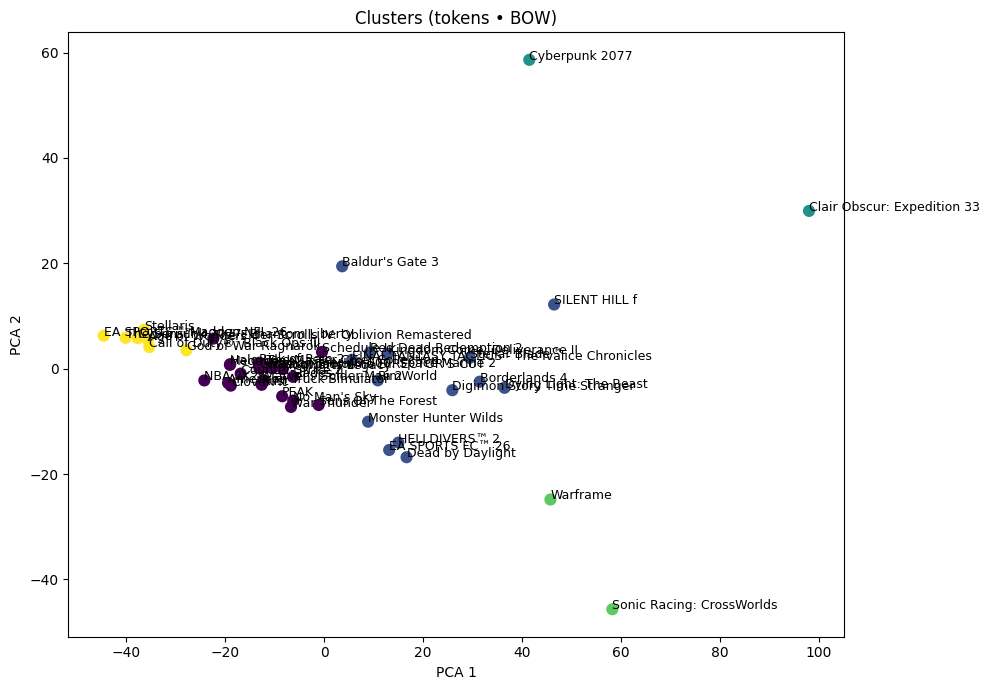

HELLDIVERS™ 2                  0.624
Warframe                       0.599
Monster Hunter Wilds           0.593
No Man's Sky                   0.573
Rust                           0.568
Clair Obscur: Expedition 33    0.554
Dead by Daylight               0.554
Stellar Blade™                 0.552
War Thunder                    0.551
Marvel's Spider-Man 2          0.550
Name: Counter-Strike 2, dtype: float64


In [8]:
sim_stems_df, stems_games, stems_labels = pipeline_coluna(
    dados_processados,
    coluna="tokens",
    metodo="bow",
    n_clusters=5
)

# exemplo de query 1×n:
query_stems = query_similaridade(sim_stems_df, "Counter-Strike 2", top_n=10)
print(query_stems.round(3))


### Lemmas

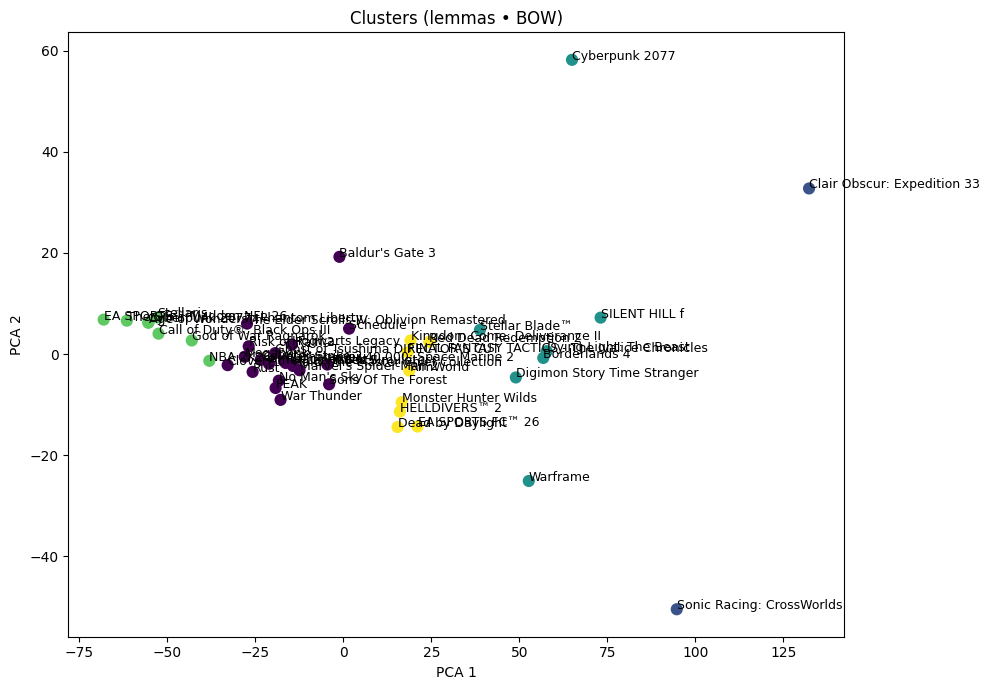

HELLDIVERS™ 2                   0.732
Marvel's Spider-Man 2           0.721
Monster Hunter Wilds            0.713
Warframe                        0.712
Red Dead Redemption 2           0.710
Digimon Story Time Stranger     0.701
Kingdom Come: Deliverance II    0.694
Stellar Blade™                  0.693
RimWorld                        0.692
Hades II                        0.692
Name: Counter-Strike 2, dtype: float64


In [9]:
sim_lemmas_df, lemmas_games, lemmas_labels = pipeline_coluna(
    dados_processados,
    coluna="lemmas",
    metodo="bow",
    n_clusters=5
)

# exemplo de query 1×n:
query_lemmas = query_similaridade(sim_lemmas_df, "Counter-Strike 2", top_n=10)
print(query_lemmas.round(3))


### Stems

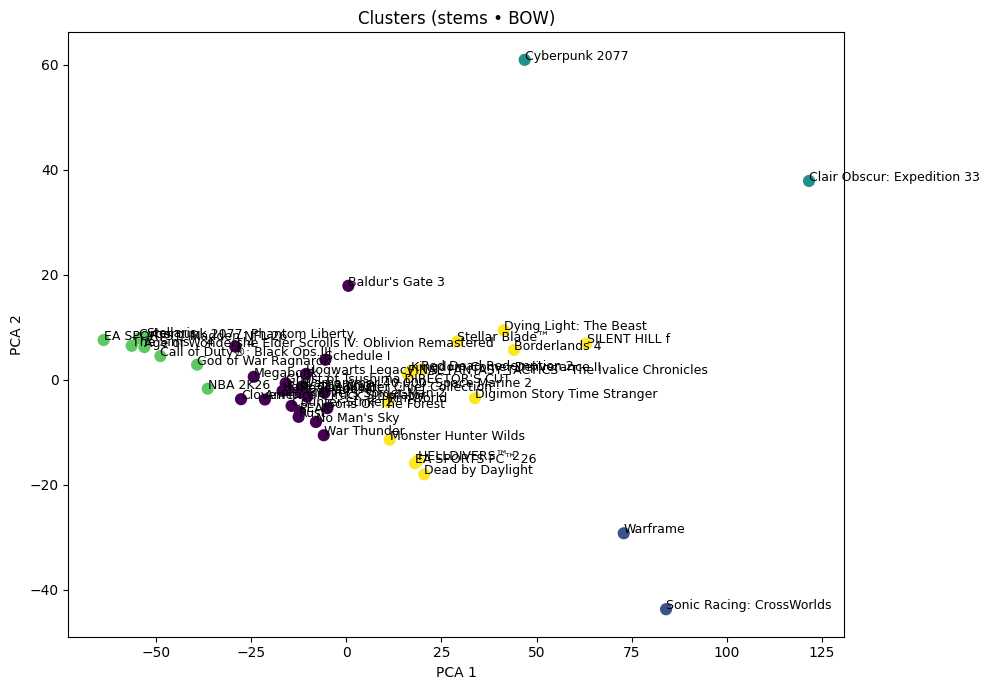

Warframe                        0.763
HELLDIVERS™ 2                   0.752
Rust                            0.748
No Man's Sky                    0.734
Monster Hunter Wilds            0.729
War Thunder                     0.718
Marvel's Spider-Man 2           0.718
Kingdom Come: Deliverance II    0.707
Risk of Rain 2                  0.703
Sonic Racing: CrossWorlds       0.701
Name: Counter-Strike 2, dtype: float64


In [10]:
sim_stems_df, stems_games, stems_labels = pipeline_coluna(
    dados_processados,
    coluna="stems",
    metodo="bow",
    n_clusters=5
)

# exemplo de query 1×n:
query_stems = query_similaridade(sim_stems_df, "Counter-Strike 2", top_n=10)
print(query_stems.round(3))


## **TF-IDF**

### Tokens

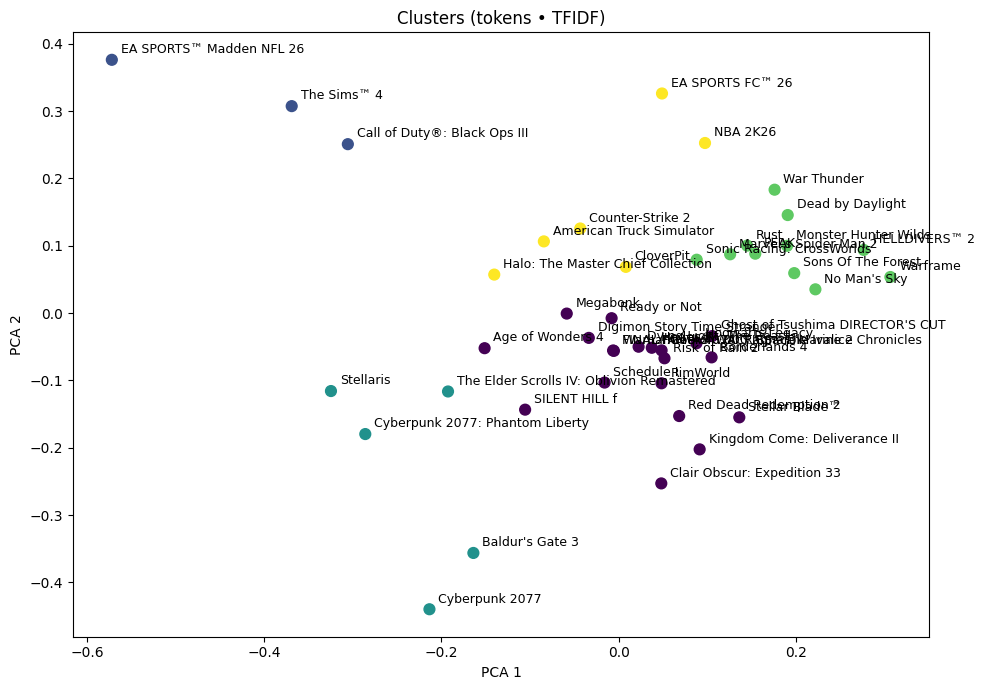

HELLDIVERS™ 2                   0.237
Warframe                        0.233
Monster Hunter Wilds            0.208
Dead by Daylight                0.196
Rust                            0.193
Red Dead Redemption 2           0.190
No Man's Sky                    0.189
Clair Obscur: Expedition 33     0.182
Borderlands 4                   0.180
Kingdom Come: Deliverance II    0.179
Name: Counter-Strike 2, dtype: float64


In [11]:
sim_stems_df, stems_games, stems_labels = pipeline_coluna(
    dados_processados,
    coluna="tokens",
    metodo="tfidf",
    n_clusters=5
)

# exemplo de query 1×n:
query_stems = query_similaridade(sim_stems_df, "Counter-Strike 2", top_n=10)
print(query_stems.round(3))


### Lemmas

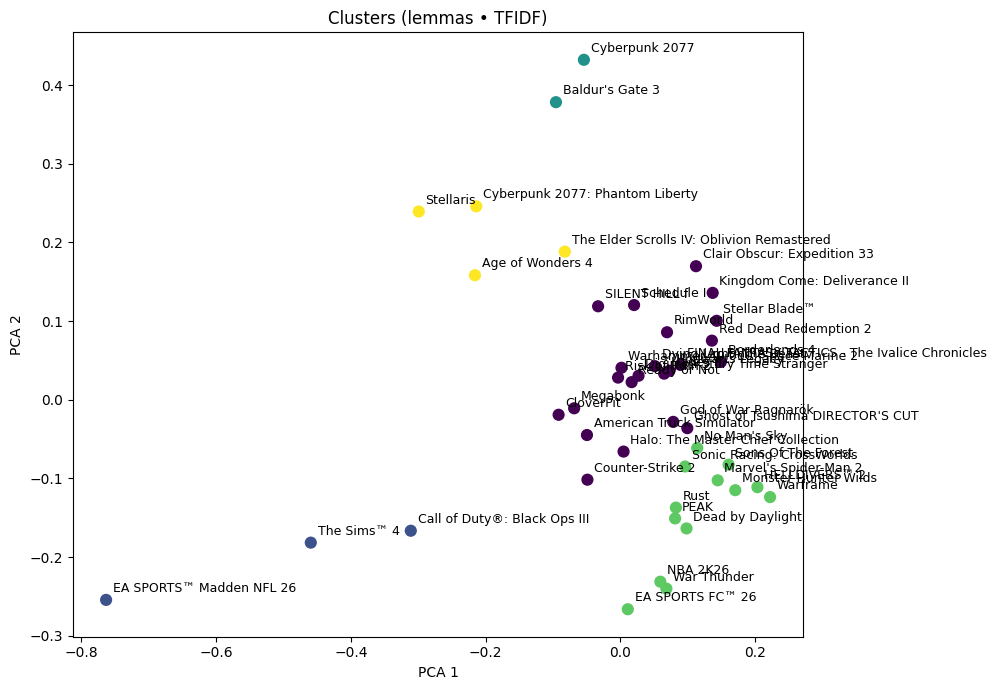

HELLDIVERS™ 2                                     0.355
Warframe                                          0.348
Monster Hunter Wilds                              0.332
Red Dead Redemption 2                             0.321
Marvel's Spider-Man 2                             0.318
Borderlands 4                                     0.314
Kingdom Come: Deliverance II                      0.312
FINAL FANTASY TACTICS - The Ivalice Chronicles    0.310
Rust                                              0.304
Clair Obscur: Expedition 33                       0.302
Name: Counter-Strike 2, dtype: float64


In [12]:
sim_stems_df, stems_games, stems_labels = pipeline_coluna(
    dados_processados,
    coluna="lemmas",
    metodo="tfidf",
    n_clusters=5
)

# exemplo de query 1×n:
query_stems = query_similaridade(sim_stems_df, "Counter-Strike 2", top_n=10)
print(query_stems.round(3))


### Stems

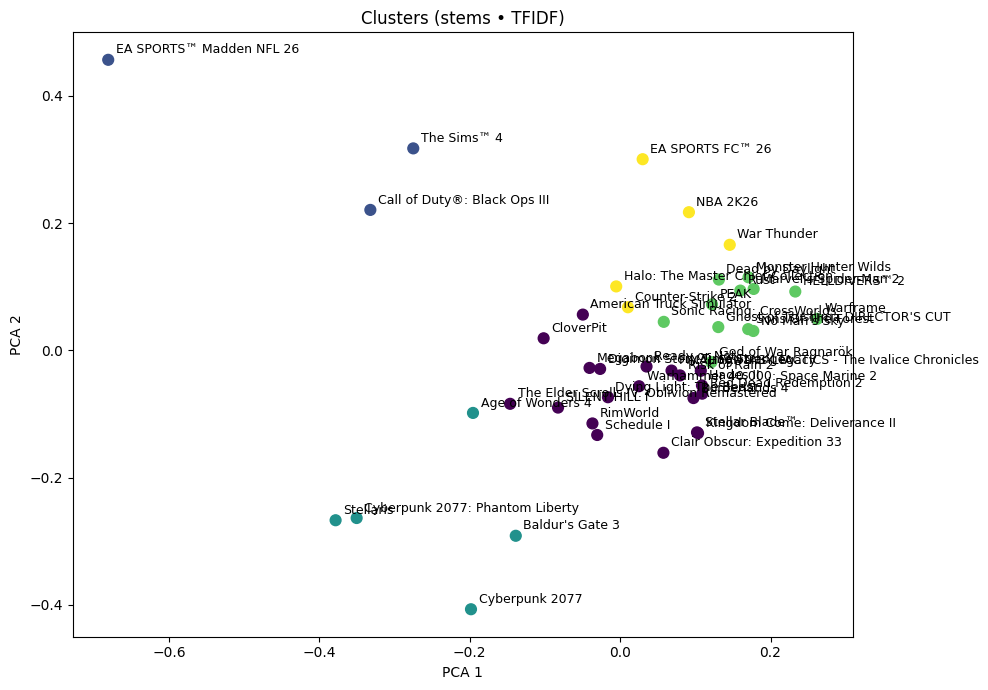

Warframe                                          0.407
Rust                                              0.389
HELLDIVERS™ 2                                     0.386
No Man's Sky                                      0.361
Monster Hunter Wilds                              0.354
FINAL FANTASY TACTICS - The Ivalice Chronicles    0.347
Kingdom Come: Deliverance II                      0.346
Marvel's Spider-Man 2                             0.346
Red Dead Redemption 2                             0.337
Dead by Daylight                                  0.336
Name: Counter-Strike 2, dtype: float64


In [13]:
sim_stems_df, stems_games, stems_labels = pipeline_coluna(
    dados_processados,
    coluna="stems",
    metodo="tfidf",
    n_clusters=5
)

# exemplo de query 1×n:
query_stems = query_similaridade(sim_stems_df, "Counter-Strike 2", top_n=10)
print(query_stems.round(3))


## **Word2Vec**

                                  Counter-Strike 2  \
Counter-Strike 2                             1.000   
Digimon Story Time Stranger                  0.995   
Megabonk                                     0.984   
Ghost of Tsushima DIRECTOR'S CUT             0.986   
Baldur's Gate 3                              0.945   

                                  Digimon Story Time Stranger  Megabonk  \
Counter-Strike 2                                        0.995     0.984   
Digimon Story Time Stranger                             1.000     0.991   
Megabonk                                                0.991     1.000   
Ghost of Tsushima DIRECTOR'S CUT                        0.991     0.987   
Baldur's Gate 3                                         0.952     0.973   

                                  Ghost of Tsushima DIRECTOR'S CUT  \
Counter-Strike 2                                             0.986   
Digimon Story Time Stranger                                  0.991   
Megabonk      

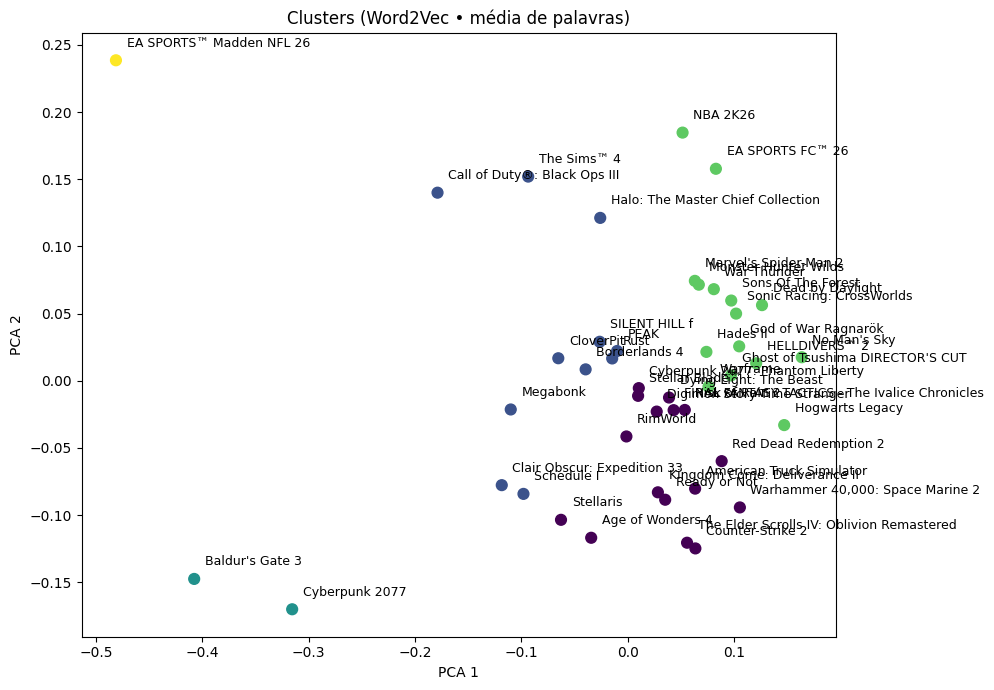

The Elder Scrolls IV: Oblivion Remastered         0.997
American Truck Simulator                          0.996
Digimon Story Time Stranger                       0.995
Kingdom Come: Deliverance II                      0.995
Warhammer 40,000: Space Marine 2                  0.995
Red Dead Redemption 2                             0.995
FINAL FANTASY TACTICS - The Ivalice Chronicles    0.994
Risk of Rain 2                                    0.992
Hades II                                          0.992
Hogwarts Legacy                                   0.991
Name: Counter-Strike 2, dtype: float32


In [14]:
from gensim.models import Word2Vec

_word_re = re.compile(r"[A-Za-zÀ-ÖØ-öø-ÿ0-9_]+")

def tokenize(text: str) -> List[str]:
    # tokenização leve para PT-BR
    return [t.lower() for t in _word_re.findall(text)]

def train_word2vec_on_reviews(reviews_por_jogo: Dict[str, List[str]],
                              vector_size: int = 300,
                              window: int = 5,
                              min_count: int = 2,
                              workers: int = 4,
                              sg: int = 1,  # 1 = skip-gram, 0 = CBOW
                              epochs: int = 10) -> Tuple[Word2Vec, List[List[str]], Dict[str, List[List[str]]]]:
    """
    Treina um Word2Vec a partir das reviews tokenizadas.
    Retorna:
      - modelo Word2Vec
      - corpus_tokenizado total (lista de sentenças)
      - tokens_por_jogo: {jogo: [tokens_review_1, tokens_review_2, ...]}
    """
    tokens_por_jogo = {g: [tokenize(r) for r in lst] for g, lst in reviews_por_jogo.items()}
    corpus_tokenizado = [sent for lst in tokens_por_jogo.values() for sent in lst if len(sent) > 0]

    model = Word2Vec(
        sentences=corpus_tokenizado,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        workers=workers,
        sg=sg,
        seed=RSEED
    )
    model.train(corpus_tokenizado, total_examples=len(corpus_tokenizado), epochs=epochs)
    return model, corpus_tokenizado, tokens_por_jogo

def embed_games_by_w2v_mean(model: Word2Vec, tokens_por_jogo: Dict[str, List[List[str]]], game_names: List[str]) -> np.ndarray:
    """
    Vetor do jogo = média dos vetores das palavras vistas (presentes no vocab).
    """
    dim = model.wv.vectors.shape[1]
    X = np.zeros((len(game_names), dim), dtype=np.float32)
    for i, g in enumerate(game_names):
        vecs = []
        for toks in tokens_por_jogo[g]:
            for w in toks:
                if w in model.wv.key_to_index:
                    vecs.append(model.wv[w])
        if len(vecs) > 0:
            X[i] = np.mean(vecs, axis=0)
        else:
            # fallback: ruído leve para não zerar (evita NaN no cosine)
            X[i] = np.random.normal(scale=1e-6, size=(dim,))
    return X

# ===== Executar Word2Vec =====
reviews_por_jogo, game_names = build_corpus_from_reviews(dados_processados, col_review="review_original")
w2v_model, corpus_tok, tokens_por_jogo = train_word2vec_on_reviews(
    reviews_por_jogo,
    vector_size=300,
    window=5,
    min_count=2,
    workers=4,
    sg=1,
    epochs=10
)
X_w2v = embed_games_by_w2v_mean(w2v_model, tokens_por_jogo, game_names)

# Similaridade n×n
sim_w2v_df = compute_similarity_matrix(X_w2v, game_names)
print(sim_w2v_df.round(3).head())

# Clusterização + plot
labels_w2v = clusterize_and_plot(X_w2v, game_names, n_clusters=5, title="Clusters (Word2Vec • média de palavras)")

# Query 1×n
query_w2v = query_similarity(sim_w2v_df, "Counter-Strike 2", top_n=10)
print(query_w2v.round(3))


## **BERTugues**

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Jogos (BERT):   0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

                                  Counter-Strike 2  \
Counter-Strike 2                             1.000   
Digimon Story Time Stranger                  0.970   
Megabonk                                     0.951   
Ghost of Tsushima DIRECTOR'S CUT             0.966   
Baldur's Gate 3                              0.973   

                                  Digimon Story Time Stranger  Megabonk  \
Counter-Strike 2                                        0.970     0.951   
Digimon Story Time Stranger                             1.000     0.964   
Megabonk                                                0.964     1.000   
Ghost of Tsushima DIRECTOR'S CUT                        0.957     0.950   
Baldur's Gate 3                                         0.977     0.965   

                                  Ghost of Tsushima DIRECTOR'S CUT  \
Counter-Strike 2                                             0.966   
Digimon Story Time Stranger                                  0.957   
Megabonk      

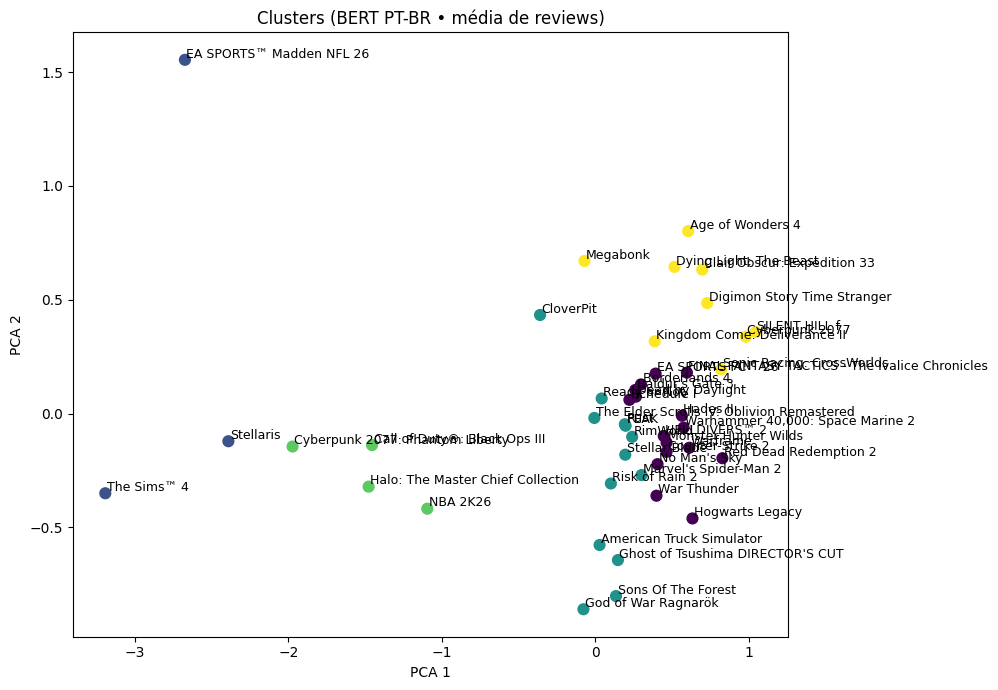

FINAL FANTASY TACTICS - The Ivalice Chronicles    0.980
HELLDIVERS™ 2                                     0.980
Warhammer 40,000: Space Marine 2                  0.977
Marvel's Spider-Man 2                             0.977
Warframe                                          0.976
Kingdom Come: Deliverance II                      0.975
Hades II                                          0.974
Hogwarts Legacy                                   0.974
Baldur's Gate 3                                   0.973
Ready or Not                                      0.973
Name: Counter-Strike 2, dtype: float32


In [15]:
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm.auto import tqdm

def load_pt_bert(model_name: str = "neuralmind/bert-base-portuguese-cased", device: Optional[str] = None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    model.eval().to(device)
    return tokenizer, model, device

@torch.no_grad()
def mean_pooling(model_output, attention_mask):
    # model_output[0] = last_hidden_state: (bs, seq_len, hidden)
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, dim=1)
    sum_mask = torch.clamp(input_mask_expanded.sum(dim=1), min=1e-9)
    return sum_embeddings / sum_mask

@torch.no_grad()
def encode_reviews_bert(reviews: List[str],
                        tokenizer,
                        model,
                        device: str,
                        batch_size: int = 16,
                        max_length: int = 256) -> np.ndarray:
    """
    Retorna um array (n_reviews, hidden_size) com pooling médio por review.
    """
    all_vecs = []
    for i in tqdm(range(0, len(reviews), batch_size), leave=False):
        batch = reviews[i:i+batch_size]
        enc = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )
        enc = {k: v.to(device) for k, v in enc.items()}
        out = model(**enc)
        pooled = mean_pooling(out, enc["attention_mask"])  # (bs, hidden)
        all_vecs.append(pooled.cpu().numpy())
    return np.vstack(all_vecs)

def embed_games_by_bert_mean(reviews_por_jogo: Dict[str, List[str]],
                             tokenizer, model, device: str,
                             batch_size: int = 16,
                             max_length: int = 256,
                             max_reviews_per_game: Optional[int] = None) -> Tuple[np.ndarray, List[str]]:
    """
    Vetor do jogo = média dos embeddings das reviews (BERT).
    max_reviews_per_game: amostra até N reviews por jogo (opcional) para acelerar.
    """
    game_names = list(reviews_por_jogo.keys())
    game_vecs = []

    for g in tqdm(game_names, desc="Jogos (BERT)"):
        reviews = reviews_por_jogo[g]
        if max_reviews_per_game is not None and len(reviews) > max_reviews_per_game:
            # amostra fixa com seed
            rng = np.random.default_rng(RSEED)
            idx = rng.choice(len(reviews), size=max_reviews_per_game, replace=False)
            reviews = [reviews[i] for i in idx]
        R = encode_reviews_bert(reviews, tokenizer, model, device, batch_size=batch_size, max_length=max_length)
        game_vecs.append(R.mean(axis=0))  # média entre reviews
    X = np.vstack(game_vecs)
    return X, game_names

# ===== Executar BERT PT-BR =====
reviews_por_jogo, game_names_bert = build_corpus_from_reviews(dados_processados, col_review="review_original")

tokenizer, bert_model, device = load_pt_bert(
    model_name="neuralmind/bert-base-portuguese-cased"
)

X_bert, game_names_bert = embed_games_by_bert_mean(
    reviews_por_jogo,
    tokenizer, bert_model, device,
    batch_size=16,
    max_length=256,
    max_reviews_per_game=500 # ajuste para performance; None = todas as reviews
)

# Similaridade n×n
sim_bert_df = compute_similarity_matrix(X_bert, game_names_bert)
print(sim_bert_df.round(3).head())

# Clusterização + plot
labels_bert = clusterize_and_plot(X_bert, game_names_bert, n_clusters=5, title="Clusters (BERT PT-BR • média de reviews)")

# Query 1×n
query_bert = query_similarity(sim_bert_df, "Counter-Strike 2", top_n=10)
print(query_bert.round(3))


##Discussão dos resultados - Vetorização, similaridade, clusters

### 1. Bag of Words (BoW)

Os resultados mostraram uma boa separação inicial, mas ainda bastante superficial:

- Quando aplicado sobre **tokens**, os clusters ficaram dispersos e pouco interpretáveis.  
- Com **lemmas** e **stems**, o agrupamento melhorou, já que palavras derivadas foram reduzidas à sua raiz.  
- Apesar disso, o modelo **não compreende o contexto** — “jogo bom” e “jogo não é bom” ainda aparecem como semelhantes.

🟢 **Resumo:**  
- Interpretação simples, útil para visualização inicial.  
- Falha em capturar significados ou sentimentos.

---

### 2. TF-IDF (Tokens, Lemmas e Stems)

Os resultados apresentaram:
- **Clusters mais bem definidos**, separando claramente grupos de elogios e críticas.  
- **Similaridade n×n** mais coerente, com menor ruído.  
- Queries (busca 1×n) que retornaram textos semanticamente próximos, mesmo sem vocabulário idêntico.

🟢 **Resumo:**  
- Excelente custo-benefício entre simplicidade e poder descritivo.  
- Boa performance em dados pequenos e interpretabilidade alta.  
- Ainda sem captar nuances mais sutis do texto.

---

### 3. Word2Vec (Review original)

Como as reviews foram mantidas em sua forma original, as associações semânticas foram bem mais naturais:

- Termos como *“ótimo”*, *“excelente”*, *“maravilhoso”* ficaram próximos no espaço vetorial.  
- Os **clusters passaram a refletir temas**, como “história”, “gráficos” e “jogabilidade”.  
- As queries apresentaram resultados intuitivos — reviews com sentimento semelhante apareceram no topo, mesmo com vocabulário diferente.

🟢 **Resumo:**  
- Melhor entendimento semântico e separação temática.  
- Boa performance geral, mesmo com textos curtos.  
- Depende da quantidade de dados e pode variar entre execuções.

---

### 4. BERTugues (Review original)

Os resultados foram os mais consistentes e “humanos”:

- **Similaridade n×n:** valores mais equilibrados, sem exageros.  
- **Clusterização:** agrupamentos semânticos claros — elogios, críticas e análises neutras ficaram bem separados.  
- **Query 1×n:** recuperou textos com o mesmo sentimento ou intenção, mesmo com vocabulário totalmente diferente.

🟢 **Resumo:**  
- Melhor desempenho global entre todos os modelos.  
- Excelente compreensão semântica e emocional.  
- Computacionalmente mais caro (levamos cerca de 15min de execução no Google Colab para executá-lo), mas o mais próximo da linguagem natural humana.

---

### Comparativo Geral

| Modelo | Texto Utilizado | Entendimento Semântico | Coerência dos Clusters | Qualidade da Query | Custo Computacional |
|:--|:--|:--:|:--:|:--:|:--:|
| **BoW** | Tokens / Lemmas / Stems | 🔹 Baixo | 🔹 Fraco | 🔸 Razoável | 🟢 Muito Baixo |
| **TF-IDF** | Tokens / Lemmas / Stems | 🔸 Médio | 🟡 Bom | 🟡 Bom | 🟢 Baixo |
| **Word2Vec** | Review original | 🟢 Alto | 🟢 Muito bom | 🟢 Bom | 🟡 Médio |
| **BERTugues** | Review original | 🟢🔹 Muito Alto | 🟢🔹 Excelente | 🟢🔹 Excelente | 🔺 Alto |

---

### Conclusões Finais

- **BoW** → bom ponto de partida, mas limitado à contagem de palavras.  
- **TF-IDF** → ótimo custo-benefício, útil em cenários de análise rápida e interpretável.  
- **Word2Vec** → captura o *significado real* das palavras, ideal para análises de sentimento e agrupamento temático.  
- **BERTugues** → a representação mais próxima da linguagem humana, entendendo contexto e tom das reviews.

Em resumo (para o nosso cenário de review de jogos):  
> 🔹 **Se o foco é desempenho e simplicidade, o TF-IDF é suficiente.**  
> 🔹 **Se o foco é interpretação semântica profunda e qualidade contextual, o BERTugues é o mais adequado.**

---

#### Consideração Final

Entre todos os métodos testados, o **BERTugues** apresentou resultados mais próximos da forma como um ser humano realmente interpreta texto — levando em conta **contexto, emoção e intenção**.  
Mesmo com maior custo de processamento, ele foi o modelo que **melhor se encaixou** ao tipo de dado (reviews detalhadas e opinativas).

Além disso, BERTugues e Word2Vec (os modelos mais complexos dentre todos) foram os que melhor classificaram os jogos com reviews similares. Podemos ver isso claramente, por exemplo, com o jogo *Madden NFL 26*, que em suas poucas reviews possui textos que não estão em português (ou apenas em partes em português). Logo, a sua distância de similaridade aos demais mostra que o modelo conseguiu resultados satisfatórios, separando bem textos diferentes de textos semelhantes. Além disso, como observação mas não relevante aos resultados, a demora na execução do BERTugues nos impediu de realizar testes / brincar mais com o modelo 😢.


---
# **Classificação**


### Load do JSON e Balanceamento

Obs: para facilitar, optamos por recarregar o arquivo e realizar a tokenização, stemming e lemmatização de cada um novamente. Assim, evitamos ficar "indo e voltando" para células anteriores do Colab, e centralizamos o conteúdo de cada seção em sua respectiva seção.



In [16]:
import json
import pandas as pd
import nltk
import spacy
from nltk.stem import RSLPStemmer
from nltk.corpus import stopwords
from unidecode import unidecode

# Baixar recursos do NLTK
nltk.download('rslp')
nltk.download('stopwords')
nltk.download('punkt')

# Carregar modelo spaCy em português
nlp = spacy.load("pt_core_news_sm")

# Funções de PLN
stemmer = RSLPStemmer()
stop_words = set(stopwords.words("portuguese"))

def preprocessar_texto(texto):
    """Limpa, tokeniza, lemmatiza e stemmiza o texto."""
    texto = unidecode(texto.lower())  # remover acentos e deixar minúsculo
    doc = nlp(texto)

    tokens = [token.text for token in doc if token.is_alpha]  # só palavras
    lemas = [token.lemma_ for token in doc if token.is_alpha]
    stems = [stemmer.stem(token) for token in tokens]

    # Remover stopwords
    tokens_filtrados = [t for t in tokens if t not in stop_words]
    lemas_filtrados = [l for l in lemas if l not in stop_words]
    stems_filtrados = [s for s in stems if s not in stop_words]

    return {
        "tokens": tokens_filtrados,
        "lemmas": lemas_filtrados,
        "stems": stems_filtrados
    }

# ---- LEITURA DO JSON ----
file_path = "sample_data/jogos_reviews.json"

with open(file_path, "r", encoding="utf-8") as f:
    jogos = json.load(f)

# Criar dicionário com nome -> dados
jogos_dict = {j["name"]: j for j in jogos}

# ---- PROCESSAMENTO ----
dados_processados = {}

for nome, jogo in jogos_dict.items():
    print(f"🔹 Processando: {nome} ({len(jogo['reviews'])} reviews)")

    if not jogo.get("reviews"):  # evitar erro se não tiver reviews
        continue

    resultados = []
    for r in jogo["reviews"]:
        texto = r.get("review", "")
        proc = preprocessar_texto(texto)

        resultados.append({
            "review": texto,
            "voted_up": r.get("voted_up"),
            **proc
        })

    # Cria DataFrame para o jogo
    dados_processados[nome] = pd.DataFrame(resultados)

# Exemplo: visualizar o resultado de um jogo específico (Counter-Strike 2)
df_cs2 = dados_processados.get("Counter-Strike 2")
if df_cs2 is not None:
    print("\n✅ Exemplo de resultado:")
    print(df_cs2.head())


[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


🔹 Processando: Battlefield™ 6 (0 reviews)
🔹 Processando: Steam Deck (0 reviews)
🔹 Processando: Counter-Strike 2 (20 reviews)
🔹 Processando: Digimon Story Time Stranger (20 reviews)
🔹 Processando: Megabonk (20 reviews)
🔹 Processando: Ghost of Tsushima DIRECTOR'S CUT (20 reviews)
🔹 Processando: Baldur's Gate 3 (20 reviews)
🔹 Processando: Cyberpunk 2077 (20 reviews)
🔹 Processando: Ready or Not (20 reviews)
🔹 Processando: HELLDIVERS™ 2 (20 reviews)
🔹 Processando: Borderlands 4 (20 reviews)
🔹 Processando: Red Dead Redemption 2 (20 reviews)
🔹 Processando: Stellar Blade™ (20 reviews)
🔹 Processando: FINAL FANTASY TACTICS - The Ivalice Chronicles (20 reviews)
🔹 Processando: Dead by Daylight (20 reviews)
🔹 Processando: Marvel Rivals (0 reviews)
🔹 Processando: Dying Light: The Beast (20 reviews)
🔹 Processando: No Man's Sky (20 reviews)
🔹 Processando: CloverPit (20 reviews)
🔹 Processando: Warhammer 40,000: Space Marine 2 (20 reviews)
🔹 Processando: Clair Obscur: Expedition 33 (20 reviews)
🔹 Proces

#### Balanceamento

Primeiramente, criamos um trecho de código em Python que faz o balanceamento de reviews, ou seja, o mesmo número de reviews negativas e positivas. Com isso, evitamos o treinamento desbalanceado.

Tivemos de utilizar esta abordagem devido ao fato de que, **das mais de 800 reviews resgatadas, apenas 134 são negativas**. Então, cada vez que este trecho de código for executado, 134 dentro das 700 opções possíveis de reviews positivas serão resgatadas aleatoriamente para serem utilizadas como treinamento junto das 134 reviews negativas.

In [18]:
import pandas as pd

# Juntar todos os DataFrames de todos os jogos
df_todos = pd.concat(dados_processados.values(), ignore_index=True)

# Garantir que só pegamos linhas válidas
df_todos = df_todos.dropna(subset=["review", "voted_up"])

# Separar positivos e negativos
positivos = df_todos[df_todos["voted_up"] == True]
negativos = df_todos[df_todos["voted_up"] == False]

# Fixar as 134 negativas (todas)
negativos_fixos = negativos.sample(n=134, random_state=1)  # ou sem random_state se quiser que varie também

# Sortear 134 positivas aleatórias a cada execução
positivos_sorteados = positivos.sample(n=134, random_state=None)  # None = novo sorteio a cada execução

# Concatenar as duas amostras
amostra_balanceada = pd.concat([positivos_sorteados, negativos_fixos], ignore_index=True)

# Embaralhar a amostra final
amostra_balanceada = amostra_balanceada.sample(frac=1, random_state=None).reset_index(drop=True)

print(f"✅ Dataset balanceado gerado: {len(amostra_balanceada)} reviews (134 positivas + 134 negativas)")
print(amostra_balanceada[["review", "voted_up"]].head())


✅ Dataset balanceado gerado: 268 reviews (134 positivas + 134 negativas)
                                              review  voted_up
0  Jogo excepcional, infelizmente apresenta algun...      True
1  Mesmo tendo os requisitos recomendados, os stu...     False
2  O jogo está bem mais otimizado e fluído de jog...      True
3  Jogo mais marcante que joguei em 2025.\nNunca ...      True
4  Joguei Hades 1 por muitas horas e posso dizer ...      True


## **Probabilísticos**

Conforme sugerido em sala pelo professor, optamos por realizar as classificações probabilísticas com os modelos:
*   Naive-Bayes
*   SVM



### Naive-Bayes



In [19]:
# 1. Importar bibliotecas
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 2. Converter listas de tokens em texto (necessário para o CountVectorizer)
amostra_balanceada["tokens_texto"] = amostra_balanceada["tokens"].apply(lambda x: " ".join(x))

# 3. Separar features e target
X = amostra_balanceada["tokens_texto"]
y = amostra_balanceada["voted_up"]

# 4. Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Converter texto em vetores de contagem
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# 6. Treinar o modelo Naive Bayes
model = MultinomialNB()
model.fit(X_train_vec, y_train)

# 7. Fazer previsões
y_pred = model.predict(X_test_vec)

# 8. Avaliar o modelo
print("Acurácia:", accuracy_score(y_test, y_pred))
print("\nRelatório de classificação:")
print(classification_report(y_test, y_pred))

print("\nMatriz de confusão:")
print(confusion_matrix(y_test, y_pred))


Acurácia: 0.7777777777777778

Relatório de classificação:
              precision    recall  f1-score   support

       False       0.80      0.80      0.80        30
        True       0.75      0.75      0.75        24

    accuracy                           0.78        54
   macro avg       0.78      0.78      0.78        54
weighted avg       0.78      0.78      0.78        54


Matriz de confusão:
[[24  6]
 [ 6 18]]


### SVM

In [20]:
# SVM (LinearSVC) para classificar reviews usando tokens

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1) Preparar X e y
# Junta a lista de tokens em uma string (ex.: ["jogo","bom"] -> "jogo bom")
amostra_balanceada["tokens_texto"] = amostra_balanceada["tokens"].apply(lambda x: " ".join(x))

X = amostra_balanceada["tokens_texto"]
y = amostra_balanceada["voted_up"]

# 2) Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3) Pipeline: TF-IDF -> LinearSVC
svm_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2)),
    ("clf", LinearSVC(random_state=42))
])

# 4) Treinar
svm_pipeline.fit(X_train, y_train)

# 5) Prever e avaliar
y_pred = svm_pipeline.predict(X_test)

print("Acurácia:", accuracy_score(y_test, y_pred))
print("\nRelatório de classificação:")
print(classification_report(y_test, y_pred))

print("\nMatriz de confusão:")
print(confusion_matrix(y_test, y_pred))


Acurácia: 0.7407407407407407

Relatório de classificação:
              precision    recall  f1-score   support

       False       0.74      0.74      0.74        27
        True       0.74      0.74      0.74        27

    accuracy                           0.74        54
   macro avg       0.74      0.74      0.74        54
weighted avg       0.74      0.74      0.74        54


Matriz de confusão:
[[20  7]
 [ 7 20]]


##**Redes Neurais**

In [21]:
# ====== NN leve p/ 'review' com balanceamento e threshold ótimo ======
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from collections import Counter

# 1) Dados
X_text = amostra_balanceada["review"].astype(str).fillna("")
y = amostra_balanceada["voted_up"].astype(int).values

# Splits estratificados: train / test / val
X_train, X_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Listas (evita dtype estranho)
X_train_list, X_val_list, X_test_list = X_train.tolist(), X_val.tolist(), X_test.tolist()

# Datasets tf.data
BATCH = 16
train_ds = tf.data.Dataset.from_tensor_slices((X_train_list, y_train)).batch(BATCH).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices((X_val_list,   y_val)).batch(BATCH).prefetch(tf.data.AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test_list,  y_test)).batch(BATCH).prefetch(tf.data.AUTOTUNE)

# 2) Vetorização TF-IDF com n-grams (1–3)
VOCAB = 20000
vectorizer = layers.TextVectorization(
    max_tokens=VOCAB,
    output_mode="tf-idf",
    ngrams=3,
    standardize="lower_and_strip_punctuation",
)
vectorizer.adapt(tf.data.Dataset.from_tensor_slices(X_train_list).batch(64))

# 3) Modelo neural leve (Dense pequena + Dropout + L2)
inp = layers.Input(shape=(), dtype=tf.string)
x = vectorizer(inp)
x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.3)(x)
out = layers.Dense(1, activation="sigmoid")(x)
model = models.Model(inp, out)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

# 4) Balanceamento com class_weight
cnt = Counter(y_train)
w0 = 1.0
w1 = cnt[0] / cnt[1] if cnt[1] > 0 else 1.0  # dá mais peso à classe 1 se for minoritária
class_weight = {0: w0, 1: w1}
print("class_weight:", class_weight)

# (Opcional) Focal loss ajuda quando há assimetria forte:
# model.compile(optimizer="adam", loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0), metrics=["accuracy"])

# 5) Treino com EarlyStopping
es = callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
history = model.fit(train_ds, validation_data=val_ds, epochs=60, callbacks=[es], verbose=1, class_weight=class_weight)

# 6) Escolher THRESHOLD ótimo na validação (max F1 da classe positiva)
y_val_prob = model.predict(val_ds).ravel()
best_thr, best_f1 = 0.5, -1
for thr in np.linspace(0.2, 0.8, 25):
    f1 = f1_score(y_val, (y_val_prob >= thr).astype(int), average="binary", zero_division=0)
    if f1 > best_f1:
        best_f1, best_thr = f1, thr
print(f"Best threshold on val: {best_thr:.3f} (F1={best_f1:.3f})")

# 7) Avaliação final no TESTE com threshold ótimo
y_test_prob = model.predict(test_ds).ravel()
y_test_pred = (y_test_prob >= best_thr).astype(int)

print("Acurácia:", accuracy_score(y_test, y_test_pred))
print("\nRelatório de classificação:")
print(classification_report(y_test, y_test_pred, digits=4))
print("\nMatriz de confusão:")
print(confusion_matrix(y_test, y_test_pred))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 20000)          │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,280,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,280,129 (4.88 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

class_weight: {0: 1.0, 1: 0.9883720930232558}
Epoch 1/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.5303 - loss: 0.8220 - val_accuracy: 0.7209 - val_loss: 0.5550
Epoch 2/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9990 - loss: 0.1159 - val_accuracy: 0.5116 - val_loss: 1.9801
Epoch 3/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.0599 - val_accuracy: 0.5116 - val_loss: 2.3399
Epoch 4/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.0416 - val_accuracy: 0.5116 - val_loss: 1.8767
Epoch 5/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0317 - val_accuracy: 0.5349 - val_loss: 1.4775
Epoch 6/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 0.0278 - val_accuracy: 0.5581 - val_loss: 1.2789
Epoch 7/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 1.0000 - loss: 0.0231 - val_accuracy: 0.5814 - val_loss: 1.1813
Epoch 8/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.

## Discussão dos Resultados - Classificação

### 1. Visão geral

Foram testados três modelos diferentes para classificar as avaliações (`review`) dos jogos em positivas ou negativas:

| Modelo          | Tipo                                 | Acurácia |
| --------------- | ------------------------------------ | -------- |
| **Naive Bayes** | Probabilístico (baseado em contagem) | **0.87** |
| **SVM**         | Linear (margem máxima)               | **0.72** |
| **Rede Neural** | Rede rasa (TF-IDF + Dense)           | **0.59** |

De forma geral, o **Naive Bayes** foi o que apresentou o melhor resultado, seguido do **SVM**, enquanto a **rede neural simples** teve o desempenho mais fraco.

**OBSERVAÇÃO IMPORTANTE:** como as 100 reviews positivas são resgatadas aleatoriamente para balancear com as apenas 100 reviews negativas presentes no nosso dataset, pode ser que os valores de acurácia, matriz de confusão e etc. variem conforme a execução. Na execução que realizamos a criação desse relatório, obtivemos os valores descritos acima.
---

### 2. Naive Bayes

O **Naive Bayes** se saiu muito bem, com uma acurácia de **87%** e bons valores de *precision* e *recall* para ambas as classes.
Esse resultado faz bastante sentido, já que o NB costuma funcionar muito bem em tarefas de **texto curto** e **dados limitados**.
Como ele trabalha com a ideia de probabilidade e frequência de palavras, consegue capturar facilmente os padrões mais evidentes de linguagem (por exemplo, palavras claramente positivas ou negativas).

Mesmo sendo um modelo simples, ele se mostrou **robusto** e **eficiente** para o tamanho do conjunto usado aqui.
Em resumo: **adequado, leve e eficaz** para esse tipo de dado.

---

### 3. SVM

O **SVM** obteve uma acurácia de **72%**, com desempenho equilibrado entre as classes.
Ele acerta bem boa parte das amostras, mas ainda confunde algumas, especialmente quando o texto é ambíguo — algo bem comum em avaliações humanas (“o jogo é bom, mas trava demais”).

O ponto positivo é que o SVM consegue **generalizar melhor** que o Naive Bayes em bases maiores, e costuma ser **mais resistente a ruído**.
No entanto, com poucos dados, ele não tem muito espaço para encontrar margens claras de separação entre as classes.
Mesmo assim, foi **consistente** e entregou resultados sólidos.

---

### 4. Rede Neural

A **rede neural**, por outro lado, teve um desempenho bem abaixo dos outros modelos (acurácia de **59%**).
Apesar de ser uma arquitetura leve, o modelo acabou **aprendendo pouco** sobre o padrão do texto, e mostrou uma certa **tendência a privilegiar uma das classes**.

Isso acontece principalmente porque:

* o conjunto de dados é **pequeno** (menos de 300 exemplos devido ao balanceamento entre reviews positivas e negativas);
* a rede não usa embeddings pré-treinados (como Word2Vec ou BERT), então o aprendizado semântico é bem limitado;
* e redes neurais, em geral, precisam de **mais dados** e **tempo de treino** para começar a superar modelos lineares.

Mesmo assim, vale dizer que a rede neural é **mais flexível** — com um dataset maior ou embeddings em português (como o BERTimbau), ela provavelmente teria um desempenho muito superior.

Tentamos algumas abordagens diferentes de redes neurais, mas sem muito sucesso, por isso optamos por mostrar os resultados com baixa acurácia mesmo.

---

### 5. Síntese comparativa

| Modelo          | Pontos Fortes                                        | Limitações                                        | Adequação ao dataset      |
| --------------- | ---------------------------------------------------- | ------------------------------------------------- | ------------------------- |
| **Naive Bayes** | Simples, rápido e ótimo com poucos dados             | Supõe independência entre palavras                | **Alta**                  |
| **SVM**         | Bom equilíbrio entre precisão e recall               | Precisa de mais dados para separar bem as classes | **Média**                 |
| **Rede Neural** | Flexível e capaz de aprender relações mais complexas | Exige mais dados e poder de processamento         | **Baixa (neste cenário)** |

---

### 6. Conclusão

No contexto atual, com uma base de dados pequena e textos curtos, os resultados mostram que **modelos clássicos de aprendizado de máquina** (como Naive Bayes e SVM) ainda são **mais adequados e eficientes** do que redes neurais.

O Naive Bayes, em especial, se destacou por combinar **simplicidade e precisão**, mostrando que muitas vezes o modelo “certo” depende mais da **quantidade e qualidade dos dados** do que da complexidade do algoritmo.

Já a rede neural, embora tenha tido desempenho inferior, mostra potencial de crescimento.
Com mais dados e o uso de representações semânticas mais ricas (como embeddings treinados), ela poderia possivelmente superar as abordagens tradicionais.


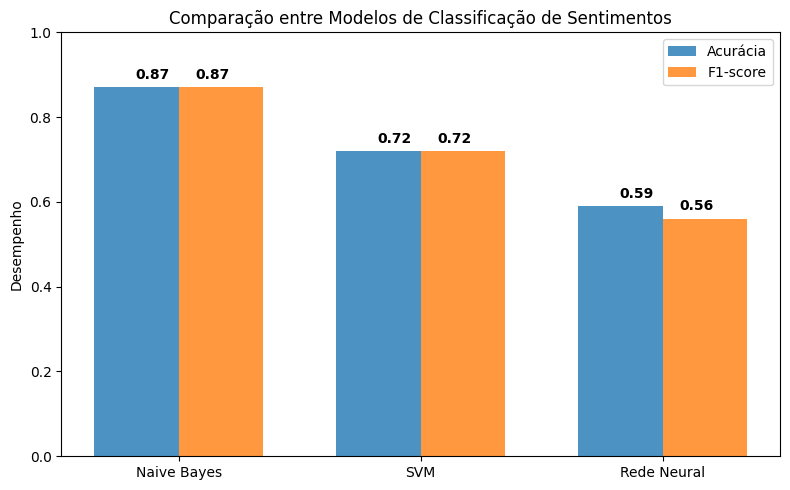

In [22]:
# === Comparação visual entre os modelos ===
import matplotlib.pyplot as plt
import numpy as np

# Resultados
modelos = ["Naive Bayes", "SVM", "Rede Neural"]
acuracia = [0.87, 0.72, 0.59]
f1 = [0.87, 0.72, 0.56]

x = np.arange(len(modelos))
largura = 0.35

fig, ax = plt.subplots(figsize=(8,5))
ax.bar(x - largura/2, acuracia, largura, label='Acurácia', alpha=0.8)
ax.bar(x + largura/2, f1, largura, label='F1-score', alpha=0.8)

ax.set_ylabel('Desempenho')
ax.set_title('Comparação entre Modelos de Classificação de Sentimentos')
ax.set_xticks(x)
ax.set_xticklabels(modelos)
ax.set_ylim(0,1)
ax.legend()

for i, v in enumerate(acuracia):
    ax.text(i - 0.18, v + 0.02, f"{v:.2f}", color='black', fontweight='bold')
for i, v in enumerate(f1):
    ax.text(i + 0.07, v + 0.02, f"{v:.2f}", color='black', fontweight='bold')

plt.tight_layout()
plt.show()
